In [3]:
# Standard imports
import io
import os
import sys

# Import libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import rasterio
import glob
import statsmodels.api as sm
import xgboost as xgb
from xgboost import XGBClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,roc_curve, auc

from sklearn.model_selection import cross_val_score
import dask.array as da
from dask.distributed import Client
import xarray as xr

# Preprocessing

In [55]:
# Define file path
file_path = os.path.join('..', 'data')

In [56]:
# Load the shapefile into a GeoDataFrame
sample_points = gpd.read_file(file_path+'/CaragaDavao-WoE-input.shp')

In [57]:
# Check Data Head
sample_points.head()

,protecteda,elevation,D_road,defo,geotype,D_rivers,D_fedge,soiltype,D_villages,slope,geometry
0,0,144,1078.716042,0,26,42.100744,0.000000,45,1935.947683,18.165319,POINT (126.34063 7.64624)
1,0,892,413.551746,0,17,347.152789,42.098464,45,442.534711,10.760324,POINT (125.26194 7.69367)
2,0,104,412.484895,0,26,319.785222,29.691304,1008,454.189745,5.921145,POINT (125.57931 9.68263)
3,0,133,149.043510,0,18,299.573748,0.000000,212,199.962852,6.228342,POINT (125.28215 6.39578)
4,0,453,1328.359630,0,26,29.703024,338.666631,45,1897.742007,7.967497,POINT (125.62809 9.40648)


In [58]:
# Define the correct order of columns
correct_order = [
                 'defo',
                 'D_fedge', 
                 'D_road', 
                 'D_rivers', 
                 'D_villages', 
                 'elevation', 
                 'slope', 
                 'geotype', 
                 'soiltype', 
                 'protecteda',
                 'geometry'
                 ]

# Rearrange the columns
sample_points = sample_points.reindex(columns=correct_order)

In [59]:
sample_points.head()

,defo,D_fedge,D_road,D_rivers,D_villages,elevation,slope,geotype,soiltype,protecteda,geometry
0,0,0.000000,1078.716042,42.100744,1935.947683,144,18.165319,26,45,0,POINT (126.34063 7.64624)
1,0,42.098464,413.551746,347.152789,442.534711,892,10.760324,17,45,0,POINT (125.26194 7.69367)
2,0,29.691304,412.484895,319.785222,454.189745,104,5.921145,26,1008,0,POINT (125.57931 9.68263)
3,0,0.000000,149.043510,299.573748,199.962852,133,6.228342,18,212,0,POINT (125.28215 6.39578)
4,0,338.666631,1328.359630,29.703024,1897.742007,453,7.967497,26,45,0,POINT (125.62809 9.40648)


/var/folders/g_/8ch6ykd15gz43_b6hrvqsm400000gn/T/ipykernel_2135/1370260271.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper left')


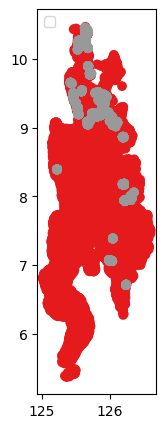

In [22]:
# Visualize the sample points
fig, ax = plt.subplots(figsize=(5, 5))

sample_points.plot(ax=ax, column='defo', legend=True, cmap='Set1', categorical=True)

# Place the legend at the upper left corner
ax.legend(loc='upper left')

plt.show()

In [60]:
# Remove 'geometry' column
sample_points.drop(columns=['geometry'], inplace=True)

### Compute Correlation

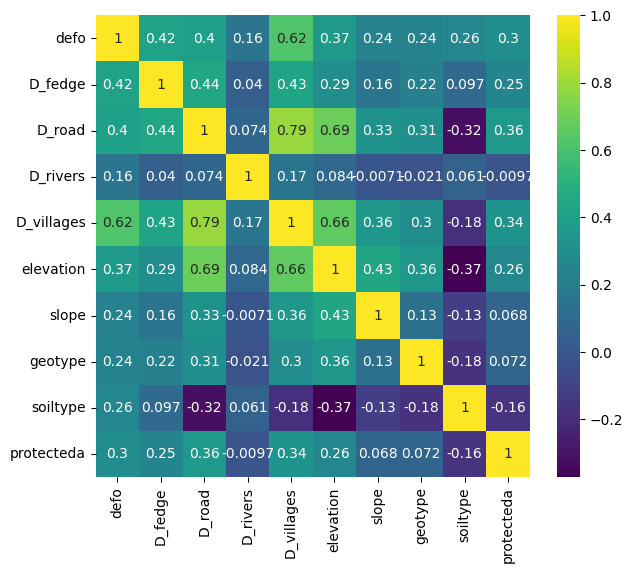

In [61]:
# Create correlation heatmap for both deforastation and non deforestation pixels
plt.figure(figsize = (7,6))
sns.heatmap(sample_points.corr(), annot = True, cmap='viridis')
plt.show()

### Compute VIF

In [62]:
# Assuming you want to calculate VIF for all columns in your DataFrame
features = sample_points.columns

# Add a constant to the DataFrame
sample_points['Intercept'] = 1

# Calculate and print VIF
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(sample_points[features].values, i) for i in range(sample_points[features].shape[1])]
vif["features"] = features
vif_sorted = vif.sort_values(by='VIF Factor', ascending=True)

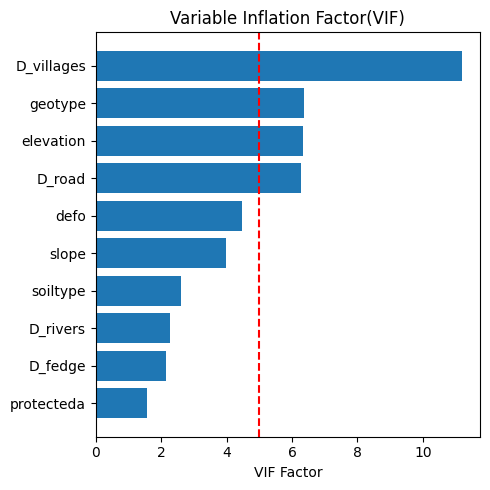

In [63]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.barh(vif_sorted['features'], width=vif_sorted['VIF Factor'])
ax.set_xlabel('VIF Factor')
ax.set_title('Variable Inflation Factor(VIF)')
ax.axvline(x=5, color='r', linestyle='--', label='VIF = 5')

plt.tight_layout()
plt.show()

In [27]:
with rasterio.open(file_path+'/subset-input-stack-8vars-subset.tif') as src:
    remain_forest_stack = src.read()
    print(remain_forest_stack.shape)

(9, 4290, 2479)


### Scale up & Handle Large Dataset

In [31]:
# # Define input raster which contains 9 input variables
# with rasterio.open('/home/simon/phl-caraga-apd/data/RF_Inputs/subset-input-stack-8vars-subset.tif) as src:
#      raster_array = src.read()
#      print(raster_array.shape)
#      remain_forest_stack = da.from_array(raster_array, chunks=(1, 1024, 1024))
#      chunk_sizes = remain_forest_stack.chunks
#      print(chunk_sizes)

In [32]:
# # Define input raster which contains 9 input variables
# with rasterio.open('/home/simon/phl-caraga-apd/data/RF_Inputs/subset-input-stack-8vars-clipped.tif') as src:
#     raster_array = src.read()
#     print(raster_array.shape)

#     # Calculate chunk size
#     chunk_size = np.gcd(raster_array.shape[1], raster_array.shape[2])

#     remain_forest_stack = da.from_array(raster_array, chunks=(1, chunk_size, chunk_size))
#     chunk_sizes = remain_forest_stack.chunks
#     print(chunk_sizes)

In [28]:
# Reshape remain_forest_stack for prediction
remain_forest_stack_reshaped = remain_forest_stack.reshape((remain_forest_stack.shape[0], -1))

# Transform the array become 2D
print("Array Shape(transformed into 2D):",remain_forest_stack_reshaped.shape)

Array Shape(transformed into 2D): (9, 10634910)


# **Model Building**

### **1. Random Forest**

In [67]:
def rf_classifier_and_report(samples, column_name, test_size, n_estimators):
    
    # Define X and y
    X = np.array(samples.drop(columns=[column_name], axis=1))
    y = np.array(samples[column_name].values)

    # Define training sample
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

    # Define Model
    rf_model = RandomForestClassifier(n_estimators=n_estimators, random_state=42)

    # Fitting the model
    rf_model.fit(X_train, y_train)

    # Predict the deforestation probability 
    y_pred_prob_rf = rf_model.predict_proba(X_test)[:, 1]

    # Predict the deforestation class
    y_pred_class_rf = rf_model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred_class_rf)
    precision = precision_score(y_test, y_pred_class_rf)
    recall = recall_score(y_test, y_pred_class_rf)
    f1 = f1_score(y_test, y_pred_class_rf)

    # Print the metrics
    # Check accuracy of the training samples
    print("Accuracy on training:{:.2f}".format(rf_model.score(X_train, y_train)))
    print(f"Accuracy on test: {format(accuracy, '.2f')}")
    print(f"Precision: {format(precision, '.2f')}")
    print(f"Recall: {format(recall, '.2f')}")
    print(f"F1 Score: {format(f1, '.2f')}")

    # Print classification report
    print("\nClassification Report:\n", classification_report(y_test, y_pred_class_rf))

    # Compute Confusion Matrix
    c_matrix = confusion_matrix(y_test, y_pred_class_rf)

    # Create a DataFrame from the confusion matrix
    names = ['Non-Deforestation', 'Deforestation']
    c_matrix_table = pd.DataFrame(c_matrix, columns=names, index=names)
    fig, ax = plt.subplots(figsize=(5, 3))
    ax = sns.heatmap(c_matrix_table, annot=True, fmt='d', cmap='YlGnBu', cbar=False)

    ax.tick_params(labelsize=8)
    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_yticklabels(names, rotation=90)

    return X, y, y_pred_prob_rf, y_pred_class_rf, y_test, rf_model

### **Apply the RF function**

Accuracy on training:1.00
Accuracy on test: 0.99
Precision: 0.98
Recall: 0.99
F1 Score: 0.99

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      3916
           1       0.98      0.99      0.99      4084

    accuracy                           0.99      8000
   macro avg       0.99      0.99      0.99      8000
weighted avg       0.99      0.99      0.99      8000



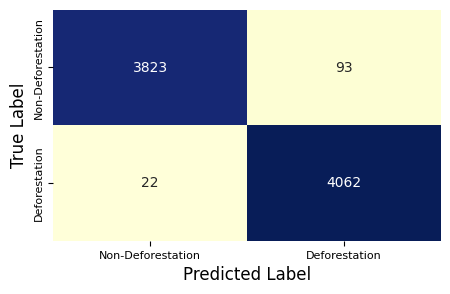

In [68]:
# Define your parameters
samples = sample_points
column_name = 'defo'
test_size = 0.2
n_estimators = 100

# Use the rf_classifier_and_report function
X, y, y_pred_prob_rf, y_pred_class_rf, y_test, rf_model = rf_classifier_and_report(samples, column_name, test_size, n_estimators)

## 2. **XGBoost**

In [66]:
def xgb_classifier_and_report(samples, column_name, test_size, booster, objective, random_state, learning_rate, n_estimators):
   
    # Define X and y
    X = np.array(samples.drop(columns=[column_name], axis=1))
    y = np.array(samples[column_name].values)

    # Define training sample
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

    # Define Model
    xgb_model = XGBClassifier(booster=booster, 
                              objective=objective, 
                              random_state=random_state,
                              learning_rate=learning_rate, 
                              n_estimators=n_estimators)

    # Fitting the model
    xgb_model.fit(X_train, y_train)

    # Predict the deforestation probability 
    y_pred_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

    # Predict the deforestation class
    y_pred_class_xgb = xgb_model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred_class_xgb)
    precision = precision_score(y_test, y_pred_class_xgb)
    recall = recall_score(y_test, y_pred_class_xgb)
    f1 = f1_score(y_test, y_pred_class_xgb)

    # Print the metrics
    print("Accuracy on training:{:.2f}".format(xgb_model.score(X_train, y_train)))
    print(f"Accuracy: {format(accuracy, '.2f')}")
    print(f"Precision: {format(precision, '.2f')}")
    print(f"Recall: {format(recall, '.2f')}")
    print(f"F1 Score: {format(f1, '.2f')}")

    # Print classification report
    print("\nClassification Report:\n", classification_report(y_test, y_pred_class_xgb))

    # Compute Confusion Matrix
    c_matrix = confusion_matrix(y_test, y_pred_class_xgb)

    # Create a DataFrame from the confusion matrix
    names = ['Non-Deforestation', 'Deforestation']
    c_matrix_table = pd.DataFrame(c_matrix, columns=names, index=names)
    fig, ax = plt.subplots(figsize=(5, 3))
    ax = sns.heatmap(c_matrix_table, annot=True, fmt='d', cmap='YlGnBu', cbar=False)

    ax.tick_params(labelsize=8)
    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_yticklabels(names, rotation=90)

    return X, y, y_pred_prob_xgb, y_pred_class_xgb, y_test, xgb_model

### **Apply the XGBoost function**

Accuracy on training:0.98
Accuracy: 0.97
Precision: 0.96
Recall: 0.99
F1 Score: 0.97

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.96      0.97      4072
           1       0.96      0.99      0.97      3928

    accuracy                           0.97      8000
   macro avg       0.98      0.98      0.97      8000
weighted avg       0.98      0.97      0.97      8000



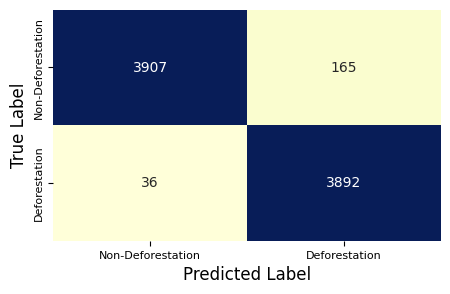

In [69]:
samples = sample_points
column_name = 'defo'
test_size = 0.2
booster = 'gbtree'
objective = 'binary:logistic'
random_state = 42
learning_rate = 0.1
n_estimators = 100

X, y, y_pred_prob_xgb, y_pred_class_xgb, y_test, xgb_model = xgb_classifier_and_report(samples, column_name, test_size, booster, objective, random_state, learning_rate, n_estimators)

# Model Training, Fitting and Predicting

In [44]:
# def predict_and_reshape(raster_data, model):
#     # If the model is a RandomForestClassifier, replace NaN values with 0
#     if isinstance(model, RandomForestClassifier):
#         np.nan_to_num(raster_data, copy=False).T

#     # Make predictions
#     prob_deforestation = model.predict_proba(raster_data)[:, 1]

#     # Reshape the predictions to match the original raster shape
#     prob_deforestation_reshaped = prob_deforestation.reshape((raster_data.shape[1], raster_data.shape[2]))

#     return prob_deforestation_reshaped

In [46]:
# prob_deforestation_reshaped_rf = predict_and_reshape(remain_forest_stack_reshaped, rf_model)
# prob_deforestation_reshaped_xgb = predict_and_reshape(remain_forest_stack_reshaped, xgb_model)

### **1. Random Forest Prediction**

In [38]:
# Transpose the array to get the shape (n_samples, n_features)
remain_forest_stack_reshaped = np.nan_to_num(remain_forest_stack_reshaped).T

# Now you can make predictions
prob_deforestation_rf = rf_model.predict_proba(remain_forest_stack_reshaped)[:, 1]

# Now reshape the array
prob_deforestation_reshaped_rf = prob_deforestation_rf.reshape((remain_forest_stack.shape[1], remain_forest_stack.shape[2]))

### **2. XGBoost Prediction**

In [39]:
# Predict the probability of deforestation
prob_deforestation_xg = xgb_model.predict_proba(remain_forest_stack_reshaped)[:, 1]

# Reshape the predicted probabilities back to the original shape
prob_deforestation_reshaped_xg = prob_deforestation_xg.reshape(remain_forest_stack.shape[1], remain_forest_stack.shape[2])

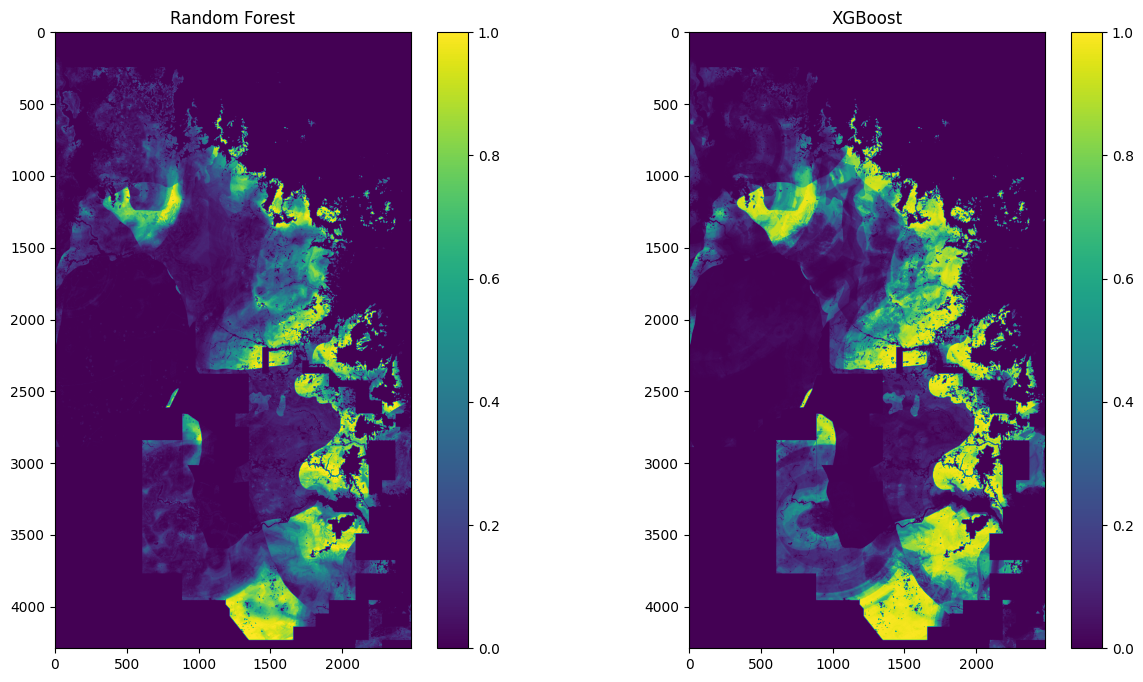

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(15,8))

# Plot the random forest predictions
im1 = axs[0].imshow(prob_deforestation_reshaped_rf, cmap='viridis', vmin=0, vmax=1)
axs[0].set_title('Random Forest')
fig.colorbar(im1, ax=axs[0], orientation='vertical')

# Plot the XGBoost predictions
im2 = axs[1].imshow(prob_deforestation_reshaped_xg, cmap='viridis', vmin=0, vmax=1)
axs[1].set_title('XGBoost')
fig.colorbar(im2, ax=axs[1], orientation='vertical')

# Display the plots
plt.show()

# Feature Importance

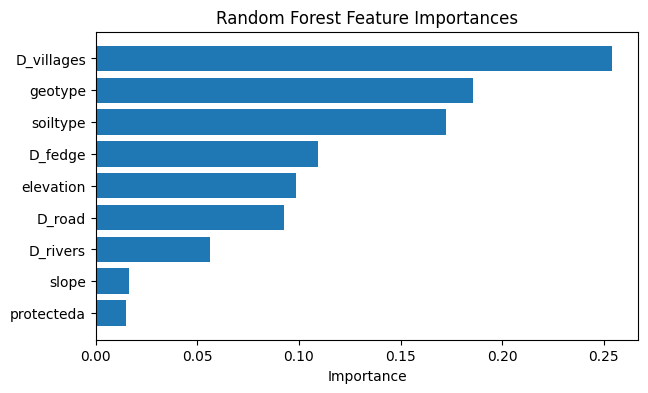

In [42]:
# Get feature importances
importances = rf_model.feature_importances_

# Convert the importances into a DataFrame
importance_df = pd.DataFrame({'feature': sample_points.drop('defo',axis=1).columns, 'importance': importances})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values('importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(7, 4))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Importance')
plt.title('Random Forest Feature Importances')
plt.gca().invert_yaxis()
plt.show()

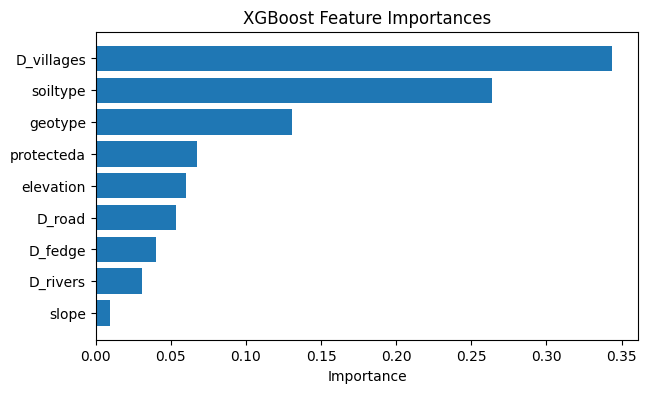

In [47]:
# Get feature importances
importances = xgb_model.feature_importances_

# Convert the importances into a DataFrame
importance_df = pd.DataFrame({'feature': sample_points.drop('defo',axis=1).columns, 'importance': importances})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values('importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(7, 4))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Importance')
plt.title('XGBoost Feature Importances')
plt.gca().invert_yaxis()
plt.show()

In [70]:
# Compute Cross Validation Score for RF
(f'5-folds cross validation:{cross_val_score(rf_model, X, y, cv=5)}')

'5-folds cross validation:[0.9865   0.987625 0.98825  0.989625 0.987875]'

In [74]:
# Compute Mean Cross Validation Score RF
(f'10-folds cross validation:{np.mean(cross_val_score(rf_model, X, y, cv=10))}')

'10-folds cross validation:0.988325'

In [71]:
# Compute Cross Validation Score for XGB
(f'10-folds cross validation:{cross_val_score(xgb_model, X, y, cv=10)}')

'10-folds cross validation:[0.977   0.97725 0.9765  0.98    0.97925 0.97975 0.979   0.98275 0.9795\n 0.982  ]'

In [75]:
# Compute Mean Cross Validation Score XGB
(f'10-folds cross validation:{np.mean(cross_val_score(xgb_model, X, y, cv=10))}')

'10-folds cross validation:0.9793'

In [26]:
from sklearn.metrics import accuracy_score, precision_score,recall_score,f1_score

In [27]:
def evaluate_preds (y_true, y_preds):

    """
    Perform evaluation comparison on y_true labels and y_preds labels on a classification model
    """
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds)
    recall = recall_score(y_true, y_preds)
    f1 = f1_score(y_true, y_preds)
    metric_dict = {
                    'accuracy': round(accuracy, 2),
                   'precision': round(precision, 2),
                   'recall': round(recall,2),
                   'f1': round(f1,2)
                    }
    print(f"Acc:{accuracy*100:.2f}%")
    print(f"Precision:{precision:.2f}")
    print(f"Recall:{recall:.2f}")
    print(f"F1:{f1:.2f}")

    return metric_dict

In [28]:
np.random.seed(42)

# Shuffle the data
sample_points_shuffled = sample_points.sample(frac=1)

# Split the data into X and y
X = sample_points_shuffled.drop('defo', axis=1)
y = sample_points_shuffled['defo']

# Split the data into train and test sets
train_split = round(0.7 * len(sample_points)) # 70% of data
valid_split = round(train_split + 0.15 * len(sample_points)) # 15% of data
X_train, y_train = X[:train_split], y[:train_split]
X_valid, y_valid = X[train_split:valid_split], y[train_split:valid_split]
X_test, y_test = X[valid_split:], y[:valid_split]

model_2 = RandomForestClassifier()
model_2.fit(X_train, y_train)

# Make baseline prediction
y_preds = model_2.predict(X_valid)

# Evaluate the classifier on validation set
baseline_metrics = evaluate_preds (y_valid,y_preds)
baseline_metrics

Acc:99.00%
Precision:0.98
Recall:1.00
F1:0.99


{'accuracy': 0.99, 'precision': 0.98, 'recall': 1.0, 'f1': 0.99}

In [29]:
len(X_train), len(X_valid), len(X_test)

(28000, 6000, 6000)

In [30]:
np.random.seed(42)

# Create a third classifier with different hyperparams
model_3 = RandomForestClassifier(n_estimators=100)
model_3.fit(X_train,y_train)

# Make predictions with different hyperparameters
y_preds_2 = model_3.predict(X_valid)

# Evaluate third model
model_3_metrics = evaluate_preds (y_valid, y_preds_2)

Acc:99.00%
Precision:0.98
Recall:1.00
F1:0.99


## Hyperparameter tuning with RandomizedSearchCV

In [31]:
from sklearn.model_selection import RandomizedSearchCV

In [32]:
grid = {
    "n_estimators" : [10, 100, 200, 500, 1000, 1200],
    "max_depth" : [None, 5, 10, 20 ,30],
    "max_features" : ["auto", "sqrt"],
    "min_samples_leaf" : [1, 2, 4]
}

np.random.seed (42)

# Split the data into X and y
X = sample_points_shuffled.drop('defo', axis=1)
y = sample_points_shuffled['defo']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Instatiate RandomForest
model_4 = RandomForestClassifier(n_jobs=1)

# RandomizedSearchCV
rs_model_4 = RandomizedSearchCV(estimator = model_4,
                                param_distributions=grid,
                                n_iter = 10, # number of models to try
                                cv= 5,
                                verbose=0)

rs_model_4.fit(X_train, y_train)

/home/simon/phl-caraga-apd/env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/simon/phl-caraga-apd/env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/simon/phl-caraga-apd/env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove thi

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=1),
                   param_distributions={'max_depth': [None, 5, 10, 20, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'n_estimators': [10, 100, 200, 500,
                                                         1000, 1200]})

In [33]:
# Find the best hyperparameters
rs_model_4.best_params_

{'n_estimators': 1200,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': None}

In [34]:
#Make predictions with the best hyperparameters
rs_y_preds = rs_model_4.predict(X_test)

# Evaluate the predictions
rs_metrics = evaluate_preds(y_test, rs_y_preds)

Acc:98.76%
Precision:0.98
Recall:0.99
F1:0.99


<Axes: >

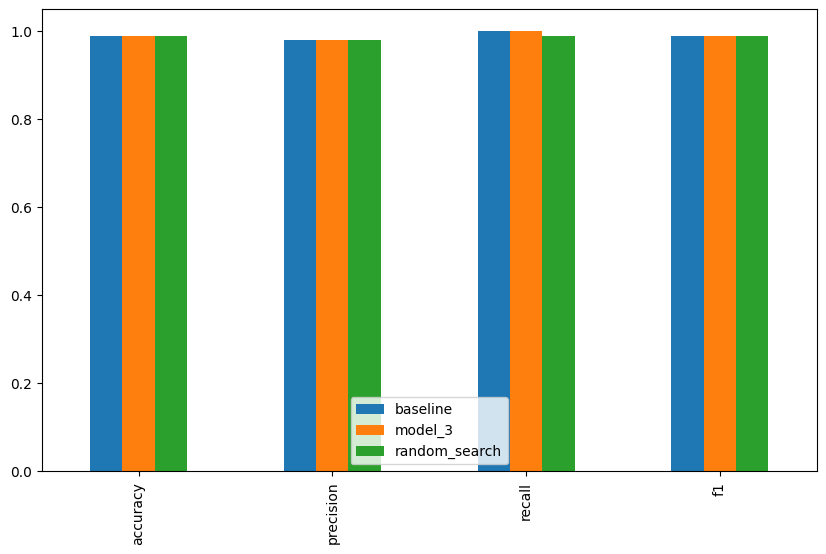

In [35]:
# Comparison
compare_metrics = pd.DataFrame({"baseline": baseline_metrics,
                                    "model_3": model_3_metrics,
                                    "random_search": rs_metrics})

# Compare metrics
compare_metrics.plot.bar(figsize=(10, 6))

In [56]:
from sklearn.metrics import roc_curve, auc

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

# Fit the classifier
rf_model.fit(X_train, y_train)

# Make prediction with probabilities
y_probs_rf = rf_model.predict_proba(X_test)

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

# Fit the classifier
model_xg.fit(X_train, y_train)

# Make prediction with probabilities
y_probs_xg = model_xg.predict_proba(X_test)

In [54]:
fpr, tpr, thresholds = roc_curve(y_test, y_probs_xg [:, 1])

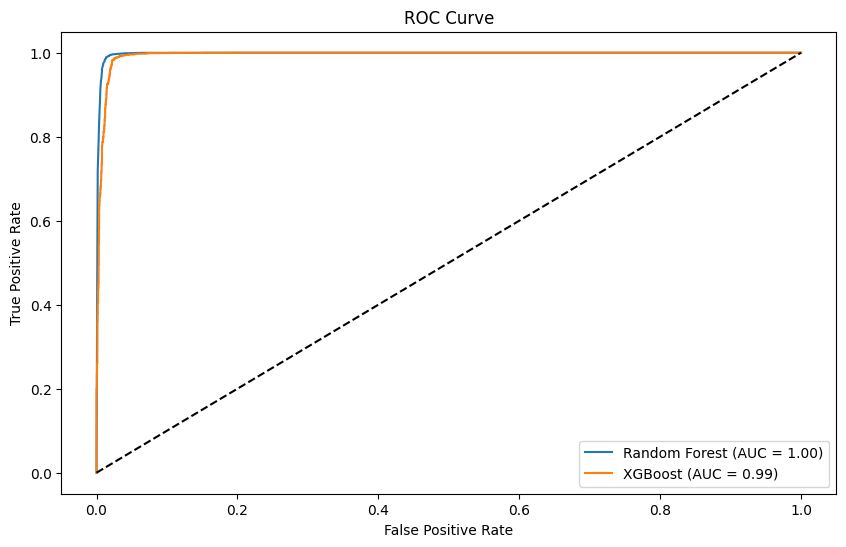

In [58]:
# Calculate the ROC curve
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_model.predict_proba(X_test)[:,1])
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, model_xg.predict_proba(X_test)[:,1])

# Calculate the AUC
rf_auc = auc(rf_fpr, rf_tpr)
xgb_auc = auc(xgb_fpr, xgb_tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.2f})')
plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost (AUC = {xgb_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

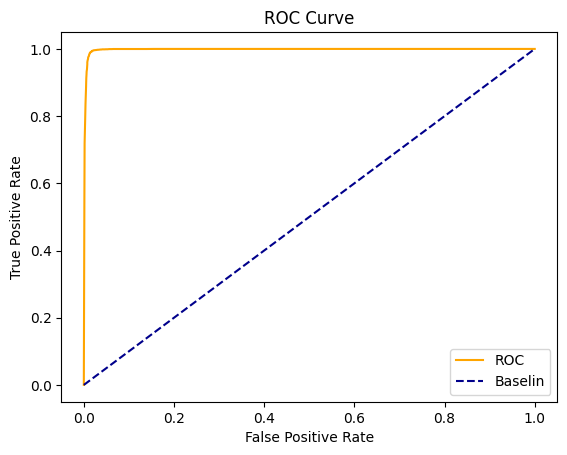

In [52]:
def plot_roc_curve (fpr,tpr):
    """
    Plots ROC curve given the false positive rate and true positive rate
    and true positive rate of the model
    """

    # Plot roc curve
    plt.plot(fpr,tpr, color='orange', label='ROC')
    # Plot line with no predictive power (baseline)
    plt.plot([0,1],[0,1], color='darkblue', linestyle='--',label="Baselin")

    # Customize the plot
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

plot_roc_curve(fpr,tpr)

# Download the raster

In [82]:
with rasterio.open(file_path+'remain-forest-input-9inputs.tif') as src:
    meta = src.meta

# Update the metadata to match the number of layers in prob_deforestation_reshaped
meta.update(count=1, dtype=rasterio.float32)

# Write prob_deforestation_reshaped to a new raster file
with rasterio.open('prob_deforestation.tif', 'w', **meta) as dst:
    dst.write(prob_deforestation_reshaped, 1)

In [83]:
import os

# Check if the file exists
if os.path.exists('prob_deforestation.tif'):
    print("File has been created successfully.")
else:
    print("File was not created.")

File has been created successfully.
